In [131]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yfin
from scipy.optimize import minimize
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

In [120]:
nvda_df = yfin.download('NVDA',start = '1990-01-01', end = '2024-07-01')['Adj Close'].pct_change().dropna()
nvda_df.head()

[*********************100%%**********************]  1 of 1 completed


Date
1999-01-25    0.104765
1999-01-26   -0.077594
1999-01-27   -0.003111
1999-01-28   -0.003144
1999-01-29   -0.047019
Name: Adj Close, dtype: float64

# Calculate Parameters
Calculate the parameters required to simulate Heston and also to determine option price using closed-form solution.

In [137]:
if adfuller(nvda_df)[1] < 0.05:
    print('Data is Stationary')
else: 
    print('Requires Differencing')

Data is Stationary


There are multiple ways to calculate the parameters for Heston, here we use a GARCH(1,1) model to determine sigma (Volatility of Volatility) and Theta (Long Run Average Variance). 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.061341644168962e+20
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5.753186370246376e+19
Iteration:      3,   Func. Count:     30,   Neg. LLF: 712578946132925.9
Iteration:      4,   Func. Count:     43,   Neg. LLF: -12699.641118907834
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12699.641082525506
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4


/Users/jasonting/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001431. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                12699.6
Distribution:                  Normal   AIC:                          -25391.3
Method:            Maximum Likelihood   BIC:                          -25364.2
                                        No. Observations:                 6380
Date:                Fri, Jul 26 2024   Df Residuals:                     6379
Time:                        20:10:02   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.5393e-03  4.257e-04      5.966  2.437e-09 [1.

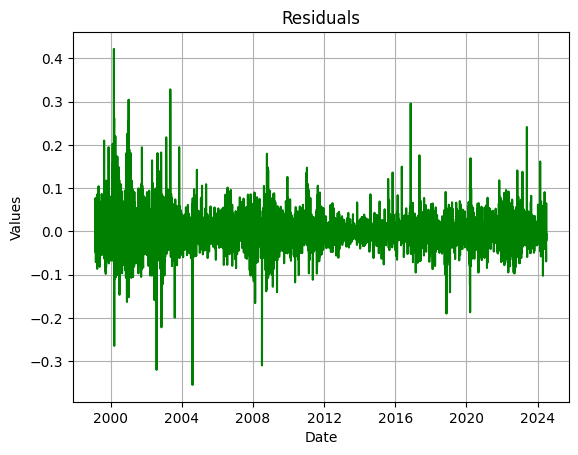

In [303]:
#Calculate Volatility Through GARCH(1,1)
garch = arch_model(nvda_df, vol='GARCH', p=1,q=1)
model = garch.fit()
display(model)
residuals = model.resid
plt.plot(residuals,color='green');plt.title('Residuals');plt.xlabel('Date');plt.ylabel('Values');plt.grid(True)

volatility = model.conditional_volatility

omega = model.params[1]
alpha = model.params[2]
beta = model.params[3]

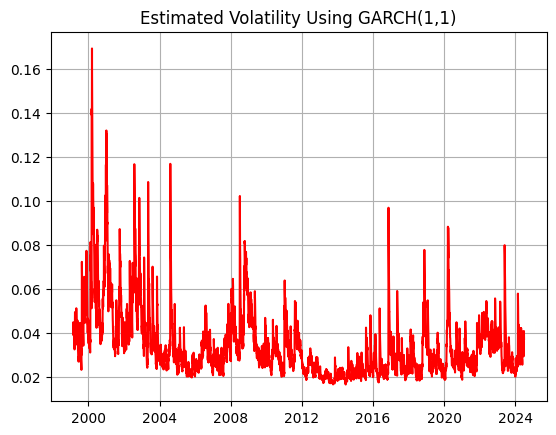

In [304]:
plt.plot(volatility,color='red');plt.title('Estimated Volatility Using GARCH(1,1)');plt.grid(True)

In [385]:
#Calculate Parameters of the Model 
mu = nvda_df.mean() #Drift
v0 = nvda_df.var() #Variance 
dt = 1 #time
rho = np.corrcoef(nvda_df, nvda_var)[0, 1] #Correlation of variance and returns
theta = omega / (1 - alpha - beta) #Theta (Long Run Average Variance)
sigma = np.std(residuals) 
k = -np.log(beta)/1 #Rate of mean reversion

S0 = yfin.download('NVDA',start = '1990-01-01', end = '2024-07-01')['Adj Close'].iloc[-1]

print('Calculated Inputs')
print(f'Mu: {mu}')
print(f'Vol: {vol}')
print(f'Delta T: {dt}')
print(f'Rho: {rho}')
print(f'Theta: {theta}')
print(f'Sigma: {sigma}')
print(f'K: {k}')
print(f'S0: {S0}')

parameters = mu, vol, dt, rho, theta, sigma, k , S0


[*********************100%%**********************]  1 of 1 completed

Calculated Inputs
Mu: 0.001970630975705051
Vol: [0.0014308 0.        0.        ... 0.        0.        0.       ]
Delta T: 1
Rho: 0.046888772183984545
Theta: 0.0014307950782865748
Sigma: 0.03782620378102229
K: 0.12783374294657007
S0: 123.54000091552734


In [386]:
T = 10000

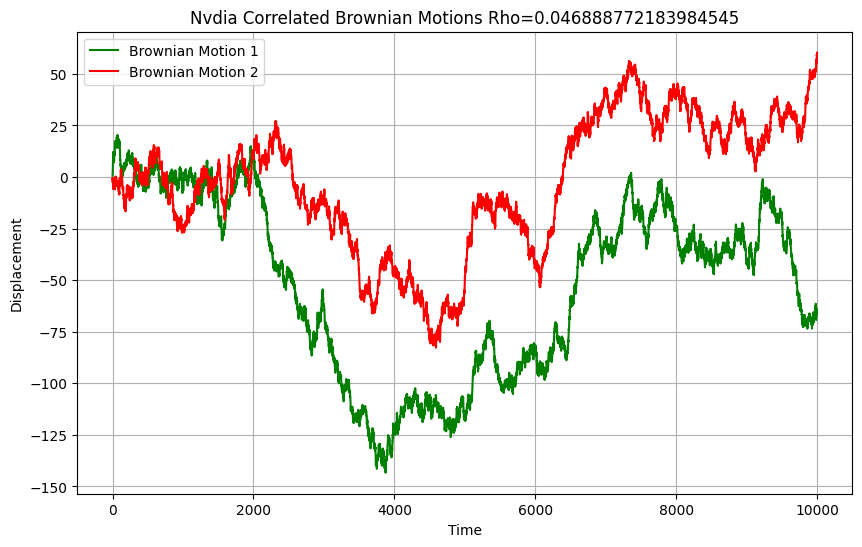

In [387]:
#Create Correlated Brownian Motion (Cholesky Decomposition)
def corr_brown(rho):
    correl_matrix = np.array([[1,rho], [rho,1]]) #Create a correlation matrix

    #Using Cholesky Decomposition
    lower_tri_matrix = np.array([[1,0],[rho,np.sqrt(1-rho**2)]]) #Create the lower triangle of the correl matrix

    #Generate Random Brownian Motions
    w1 = np.random.normal(0,np.sqrt(1),T)
    w2 = np.random.normal(0,np.sqrt(1),T)

    #Put w1 and w2 into a 2x2 matrix 
    w_matrix = [w1,w2] 
    
    return w1,w2


w1,w2 = corr_brown(rho=rho)

correlated_brownian_motions = lower_tri_matrix @ w_matrix #Dot Product with Lower Triangle Matrix

# Cumulative sum to simulate Brownian motion paths
brown1 = correlated_brownian_motions[0].cumsum()
brown2 = correlated_brownian_motions[1].cumsum()
x_vector = np.arange(0, T)

# Plotting Correlated Brownian Motions
plt.figure(figsize=(10, 6))
plt.plot(x_vector, brown1, label='Brownian Motion 1', color='green')
plt.plot(x_vector, brown2, label='Brownian Motion 2', color='red')
plt.title(f'Nvdia Correlated Brownian Motions Rho={rho}')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.grid(True)
plt.legend()  
plt.show()




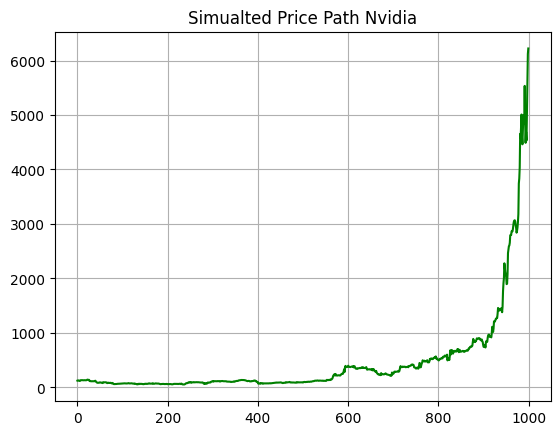

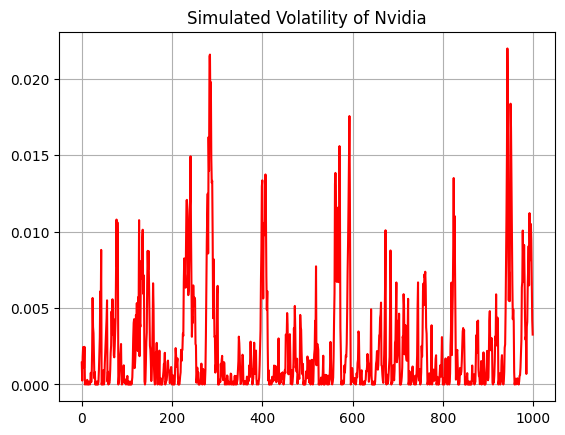

In [388]:
def heston_model_sim(parameters, T,w1,w2):
    mu, vol, dt, rho, theta, sigma, k, S0 = parameters
    asset_price = np.zeros(T)
    asset_price[0] = S0
    volatility = np.zeros(T)
    volatility[0] = theta

    for i in range(1, T):
       
        # Update volatility
        volatility[i] = (volatility[i-1] + k * (theta - volatility[i-1]) * dt + sigma * np.sqrt(volatility[i-1] * dt) * w2[i-1])
        
        # Ensure non-negativity of volatility
        if volatility[i] < 0:
            volatility[i] = 0
        
        # Update asset price
        asset_price[i] = (asset_price[i-1] * np.exp((mu - 0.5 * volatility[i-1]) * dt + np.sqrt(volatility[i-1] * dt) * w1[i-1]))
        
    return asset_price, volatility


p, v = heston_model_sim(parameters, 1000, w1, w2)

plt.plot(p, color ='green');plt.grid(True);plt.title('Simualted Price Path Nvidia');plt.show()
plt.plot(v, color ='red');plt.grid(True);plt.title('Simulated Volatility of Nvidia');plt.show()

In [391]:
def monte_carlo(num_sims,parameters):
    prices = []
    vols = []
    for i in range(num_sims):
        rho = parameters[3]
        w1, w2 = corr_brown(rho)
        p, v = heston_model_sim(parameters, 1000, w1, w2)
        prices.append(p)
        vols.append(v)
        
    return prices, vols
    
p, v = monte_carlo(10, parameters)  

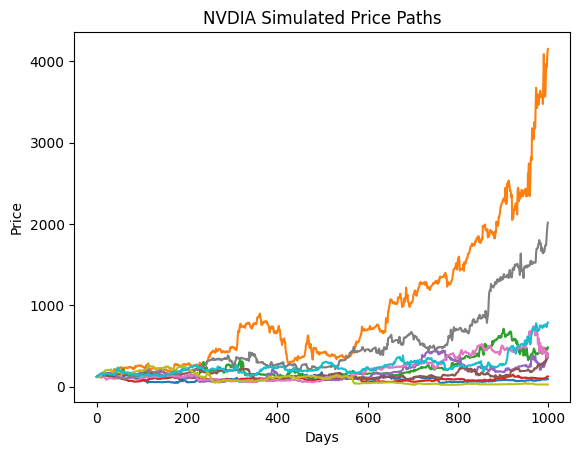

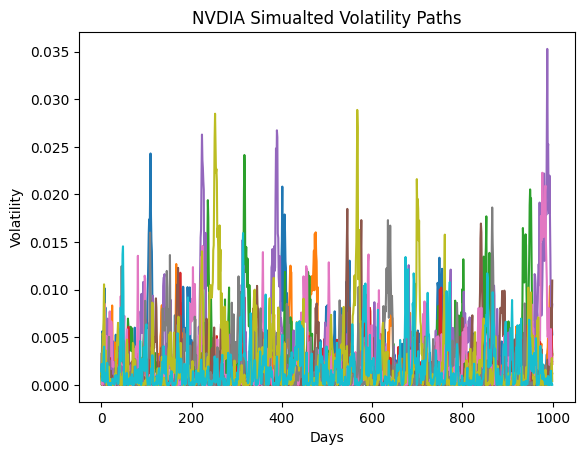

In [392]:
for i in range(len(p)):
    plt.plot(p[i]);plt.title('NVDIA Simulated Price Paths');plt.ylabel('Price');plt.xlabel('Days')
plt.show()    

for i in range(len(v)):
    plt.plot(v[i]);plt.title('NVDIA Simualted Volatility Paths');plt.ylabel('Volatility');plt.xlabel('Days')
plt.show()
    